https://docs.opencv.org/3.4/d2/df0/tutorial_py_hdr.html

images from https://en.wikipedia.org/wiki/Multi-exposure_HDR_capture


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob


In [2]:
img_filenames = glob.glob(os.path.relpath("../../Data/HDR_images/HDRI_Sample_*.jpg"))
img_filenames.sort()
img_list = [cv2.imread(file) for file in img_filenames]

img_list=[cv2.cvtColor(img_list[idx],cv2.COLOR_BGR2RGB) for idx in range(0,len(img_list))]

# The images are -6 stops to 5 stops.  Stops are powers of 2 
exposure_times=np.array([1/1000,1/500,1/250,1/125,1/60,1/30,1/15,1/8,1/4,1/2,1,2],dtype=np.float32)

# Read from metadata in picture
#Exposure time	1/1,000; 1/500; 1/250; 1/125; 1/60... 
#F-number	f/7.7
#ISO speed rating	100
#Lens focal length	8.9 mm


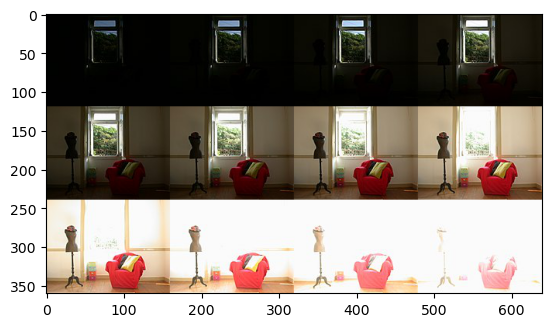

In [4]:
imAll = cv2.vconcat([cv2.hconcat([img_list[0],img_list[1],img_list[2],img_list[3]]),\
                     cv2.hconcat([img_list[4],img_list[5],img_list[6],img_list[7]]),\
                     cv2.hconcat([img_list[8],img_list[9],img_list[10],img_list[11]])])
plt.imshow(imAll)

In [5]:
# Align input images
#alignMTB = cv2.createAlignMTB()
#alignMTB.process(img_list,img_list)

In [6]:
merge_debevec = cv2.createMergeDebevec()
hdr_debevec = merge_debevec.process(img_list, times=exposure_times.copy())
merge_robertson = cv2.createMergeRobertson()
hdr_robertson = merge_robertson.process(img_list, times=exposure_times.copy())

# Tonemap HDR image
tonemap1 = cv2.createTonemap(gamma=2.2)

res_debevec = tonemap1.process(hdr_debevec.copy())
res_robertson = tonemap1.process(hdr_robertson.copy())

# Remove the NaN
lst=np.where(np.isnan(res_debevec))
res_debevec[lst[0],lst[1],lst[2]]=0

# Exposure fusion using Mertens
merge_mertens = cv2.createMergeMertens()
res_mertens = merge_mertens.process(img_list)

# Remove the NaN
lst=np.where(np.isnan(res_robertson))
res_robertson[lst[0],lst[1],lst[2]]=0


[ WARN:0@2.015] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/matrix_expressions.cpp (1334) assign OpenCV/MatExpr: processing of multi-channel arrays might be changed in the future: https://github.com/opencv/opencv/issues/16739


In [7]:
# Convert datatype to 8-bit and save
res_debevec_8bit = np.clip(res_debevec*255, 0, 255).astype('uint8')
res_robertson_8bit = np.clip(res_robertson*255, 0, 255).astype('uint8')
res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8')

Text(0.5, 1.0, 'mertens')

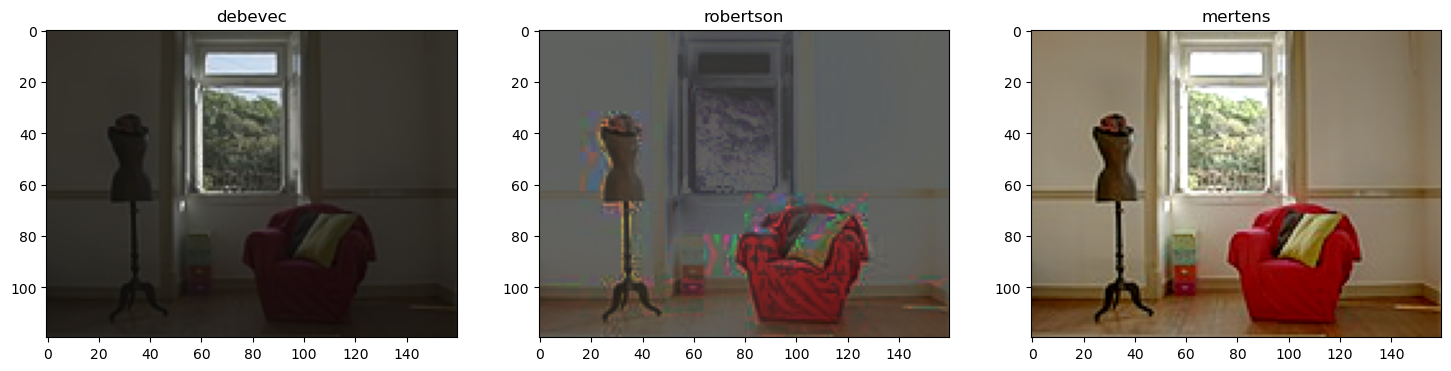

In [8]:
# Show the images
plt.figure(figsize=[18, 5])

plt.subplot(131); plt.imshow(res_debevec_8bit); plt.title('debevec')
plt.subplot(132); plt.imshow(res_robertson_8bit); plt.title('robertson')
plt.subplot(133); plt.imshow(res_mertens_8bit); plt.title('mertens')

In [9]:
# Estimate camera response function (CRF)
merge_debevec = cv2.createMergeDebevec()
cal_debevec = cv2.createCalibrateDebevec()
crf_debevec = cal_debevec.process(img_list, times=exposure_times)
hdr_debevec = merge_debevec.process(img_list, times=exposure_times.copy(), response=crf_debevec.copy())
hdr_debevec=hdr_debevec/hdr_debevec.max()


merge_robertson = cv2.createMergeRobertson()
cal_robertson = cv2.createCalibrateRobertson()
crf_robertson = cal_robertson.process(img_list, times=exposure_times)
hdr_robertson = merge_robertson.process(img_list, times=exposure_times.copy(), response=crf_robertson.copy())
hdr_robertson=hdr_robertson/hdr_robertson.max()

# Convert datatype to 8-bit and save
hdr_debevec_8bit = np.clip(hdr_debevec*255, 0, 255).astype('uint8')
hdr_robertson_8bit = np.clip(hdr_robertson*255, 0, 255).astype('uint8')


Text(0.5, 1.0, 'mertens')

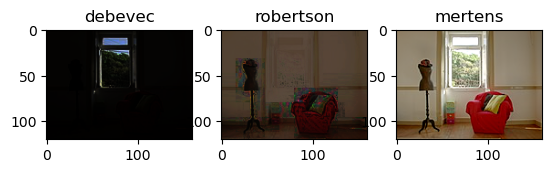

In [10]:
plt.subplot(131); plt.imshow(hdr_debevec_8bit); plt.title('debevec')
plt.subplot(132); plt.imshow(hdr_robertson_8bit); plt.title('robertson')
plt.subplot(133); plt.imshow(res_mertens_8bit); plt.title('mertens')

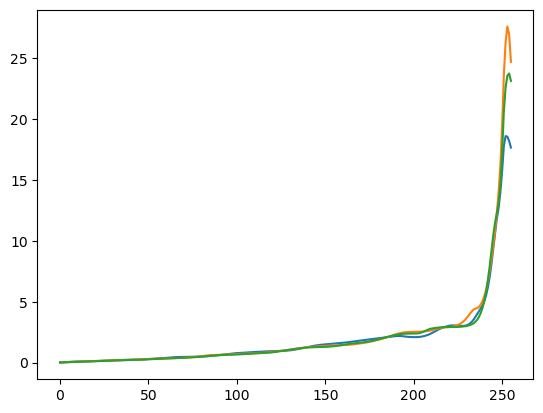

In [11]:
plt.plot(crf_debevec[:,0,2])
plt.plot(crf_debevec[:,0,0])
plt.plot(crf_debevec[:,0,1])

In [12]:
crf_debevec.shape

(256, 1, 3)